<a href="https://colab.research.google.com/github/roshdwivedi/ESC_classifier/blob/main/classifier_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchaudio pandas tensorboard tqdm torchinfo torchviz netron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 80.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Import necessary libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import torchaudio.transforms as T
import random
from torchviz import make_dot

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


Dataset Class Implementation

In [ ]:
class ImprovedESC50Dataset(Dataset):
    def __init__(self, preprocessed_dir, metadata_file, split='train', aug_params=None):
        self.preprocessed_dir = os.path.join(preprocessed_dir, split)
        self.metadata = pd.read_csv(metadata_file)
        self.split = split

        # Default augmentation parameters
        self.aug_params = {
            'mixup_alpha': 0.3,
            'time_mask_param': 30,
            'freq_mask_param': 10,
            'time_mask_num': 2,
            'freq_mask_num': 2,
            'prob': 0.6
        }
        if aug_params:
            self.aug_params.update(aug_params)

        # Initialize augmentations
        if split == 'train':
            self.time_mask = T.TimeMasking(time_mask_param=self.aug_params['time_mask_param'])
            self.freq_mask = T.FrequencyMasking(freq_mask_param=self.aug_params['freq_mask_param'])

        # Filter metadata based on split
        if split == 'train':
            self.metadata = self.metadata[self.metadata['fold'].isin([1, 2, 3])]
        elif split == 'val':
            self.metadata = self.metadata[self.metadata['fold'] == 4]
        else:  # test
            self.metadata = self.metadata[self.metadata['fold'] == 5]

    def apply_augmentation(self, mel_spec):
        mel_spec = mel_spec.unsqueeze(0)

        # Apply time masking
        for _ in range(self.aug_params['time_mask_num']):
            if random.random() < self.aug_params['prob']:
                mel_spec = self.time_mask(mel_spec)

        # Apply frequency masking
        for _ in range(self.aug_params['freq_mask_num']):
            if random.random() < self.aug_params['prob']:
                mel_spec = self.freq_mask(mel_spec)

        return mel_spec.squeeze(0)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_name = row['filename'].replace('.wav', '.pt')
        file_path = os.path.join(self.preprocessed_dir, file_name)

        data = torch.load(file_path, weights_only=True)
        mel_spec = data['mel_spec']

        if len(mel_spec.shape) > 2:
            mel_spec = mel_spec.squeeze()

        if self.split == 'train':
            mel_spec = self.apply_augmentation(mel_spec)

        return mel_spec, data['label']

Model Architecture Components

In [ ]:
class EnhancedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, pool_size=(2, 2), pool_type='avg+max'):
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))

        if pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)

        return x

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel * 2, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_y = self.avg_pool(x).view(b, c)
        max_y = self.max_pool(x).view(b, c)
        y = torch.cat([avg_y, max_y], dim=1)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

Main Model Class

In [ ]:
class ImprovedESC50Classifier(nn.Module):
    def __init__(self, num_classes=50):
        super(ImprovedESC50Classifier, self).__init__()


        self.conv_block1 = EnhancedConvBlock(1, 64)
        self.conv_block2 = EnhancedConvBlock(64, 128)
        self.conv_block3 = EnhancedConvBlock(128, 256)
        self.conv_block4 = EnhancedConvBlock(256, 512)
        self.conv_block5 = EnhancedConvBlock(512, 1024)

        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)
        self.se4 = SEBlock(1024)

        self.embedding_size = 2048
        self.fc1 = nn.Linear(1024, self.embedding_size)
        self.fc2 = nn.Linear(self.embedding_size, num_classes)

    def forward(self, x):
        print("Input spectrogram shape:", x.shape)
        if len(x.shape) == 2:
            x = x.unsqueeze(0).unsqueeze(0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(1)


        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg+max')
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg+max')
        x = self.se1(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg+max')
        x = self.se2(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg+max')
        x = self.se3(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg+max')
        x = self.se4(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = torch.mean(x, dim=3)
        x1, _ = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        embedding = F.relu_(self.fc1(x))
        x = F.dropout(embedding, p=0.5, training=self.training)
        output = self.fc2(x)

        return output, embedding

Data Mixup Criterion

In [ ]:
def mixup_data(x, y, alpha=0.3):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Trainer Class

In [ ]:
class ImprovedESC50Trainer:
    def __init__(self, model, train_loader, val_loader, config, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=config['learning_rate'],
            epochs=config['num_epochs'],
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            div_factor=25,
            final_div_factor=1000
        )

        self.writer = SummaryWriter('/content/drive/MyDrive/logs_model/logs_2')

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.config["num_epochs"]}')

        for batch_idx, (features, labels) in enumerate(pbar):
            features, labels = features.to(self.device), labels.to(self.device)

            if random.random() < 0.65:  # Apply mixup 50% of the time
                features, labels_a, labels_b, lam = mixup_data(features, labels,
                                                             self.config['augmentation']['mixup_alpha'])
                self.optimizer.zero_grad()
                outputs, _ = self.model(features)
                loss = mixup_criterion(self.criterion, outputs, labels_a, labels_b, lam)
            else:
                self.optimizer.zero_grad()
                outputs, _ = self.model(features)
                loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%',
                'lr': f'{self.scheduler.get_last_lr()[0]:.6f}'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        self.writer.add_scalar('Loss/train', epoch_loss, epoch)
        self.writer.add_scalar('Accuracy/train', epoch_acc, epoch)

        return epoch_loss, epoch_acc

    @torch.no_grad()
    def validate(self, epoch):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        for features, labels in tqdm(self.val_loader, desc='Validation'):
            features, labels = features.to(self.device), labels.to(self.device)

            outputs, _ = self.model(features)
            loss = self.criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        self.writer.add_scalar('Loss/val', epoch_loss, epoch)
        self.writer.add_scalar('Accuracy/val', epoch_acc, epoch)

        return epoch_loss, epoch_acc

    def train(self):
        best_acc = 0
        for epoch in range(self.config['num_epochs']):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(epoch)

            print(f"\nEpoch {epoch + 1}/{self.config['num_epochs']}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
            print("-" * 60)

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'val_acc': val_acc,
                }, '/content/drive/MyDrive/logs_model/improved_best_model.pth')

        self.writer.close()
        print(f"Training completed! Best validation accuracy: {best_acc:.2f}%")

Training Configuration and Execution

In [ ]:
def main():
    config = {
        'preprocessed_dir': '/content/drive/MyDrive/ESC-50-Dataset/preprocessed',
        'metadata_file': '/content/drive/MyDrive/ESC-50-Dataset/ESC-50-master/meta/esc50.csv',
        'batch_size': 28,
        'learning_rate': 0.0001,
        'num_epochs': 300,
        'weight_decay': 0.001,
        'num_workers': 2,
        'num_classes': 50,
        'augmentation': {
            'time_mask_param': 24,
            'freq_mask_param': 10,
            'time_mask_num': 3,
            'freq_mask_num': 3,
            'prob': 0.6,
            'mixup_alpha': 0.4
        }
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        # Create datasets with augmentation parameters
        train_dataset = ImprovedESC50Dataset(
            preprocessed_dir=config['preprocessed_dir'],
            metadata_file=config['metadata_file'],
            split='train',
            aug_params=config['augmentation']  # Pass augmentation params here
        )

        # Validation dataset (no augmentation needed)
        val_dataset = ImprovedESC50Dataset(
            preprocessed_dir=config['preprocessed_dir'],
            metadata_file=config['metadata_file'],
            split='val'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=config['num_workers'],
            pin_memory=True
        )

        model = ImprovedESC50Classifier(num_classes=config['num_classes'])
        trainer = ImprovedESC50Trainer(model, train_loader, val_loader, config, device)

        trainer.train()

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Using device: cuda


Epoch 1/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/300
Train Loss: 4.2147, Train Accuracy: 1.50%
Val Loss: 3.9208, Val Accuracy: 2.00%
------------------------------------------------------------


Epoch 2/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 2/300
Train Loss: 4.0483, Train Accuracy: 1.75%
Val Loss: 3.8919, Val Accuracy: 6.00%
------------------------------------------------------------


Epoch 3/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 3/300
Train Loss: 3.9496, Train Accuracy: 3.67%
Val Loss: 3.8585, Val Accuracy: 5.75%
------------------------------------------------------------


Epoch 4/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 4/300
Train Loss: 3.9144, Train Accuracy: 4.33%
Val Loss: 3.8324, Val Accuracy: 4.00%
------------------------------------------------------------


Epoch 5/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 5/300
Train Loss: 3.8206, Train Accuracy: 4.25%
Val Loss: 3.7908, Val Accuracy: 5.50%
------------------------------------------------------------


Epoch 6/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 6/300
Train Loss: 3.7950, Train Accuracy: 4.58%
Val Loss: 3.7384, Val Accuracy: 6.00%
------------------------------------------------------------


Epoch 7/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 7/300
Train Loss: 3.7325, Train Accuracy: 5.50%
Val Loss: 3.6680, Val Accuracy: 8.50%
------------------------------------------------------------


Epoch 8/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 8/300
Train Loss: 3.6123, Train Accuracy: 8.25%
Val Loss: 3.6226, Val Accuracy: 6.25%
------------------------------------------------------------


Epoch 9/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 9/300
Train Loss: 3.5607, Train Accuracy: 9.42%
Val Loss: 3.4327, Val Accuracy: 13.00%
------------------------------------------------------------


Epoch 10/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 10/300
Train Loss: 3.4583, Train Accuracy: 10.33%
Val Loss: 3.3088, Val Accuracy: 14.00%
------------------------------------------------------------


Epoch 11/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 11/300
Train Loss: 3.3650, Train Accuracy: 11.83%
Val Loss: 3.2556, Val Accuracy: 15.75%
------------------------------------------------------------


Epoch 12/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 12/300
Train Loss: 3.2732, Train Accuracy: 13.83%
Val Loss: 3.2925, Val Accuracy: 16.75%
------------------------------------------------------------


Epoch 13/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 13/300
Train Loss: 3.1783, Train Accuracy: 14.58%
Val Loss: 3.2411, Val Accuracy: 17.50%
------------------------------------------------------------


Epoch 14/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 14/300
Train Loss: 3.1185, Train Accuracy: 16.67%
Val Loss: 2.9910, Val Accuracy: 24.50%
------------------------------------------------------------


Epoch 15/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 15/300
Train Loss: 2.9898, Train Accuracy: 21.58%
Val Loss: 2.6045, Val Accuracy: 35.75%
------------------------------------------------------------


Epoch 16/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 16/300
Train Loss: 2.9204, Train Accuracy: 20.75%
Val Loss: 2.6375, Val Accuracy: 33.50%
------------------------------------------------------------


Epoch 17/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 17/300
Train Loss: 2.7393, Train Accuracy: 26.33%
Val Loss: 2.4700, Val Accuracy: 37.50%
------------------------------------------------------------


Epoch 18/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 18/300
Train Loss: 2.7079, Train Accuracy: 31.00%
Val Loss: 2.6372, Val Accuracy: 36.75%
------------------------------------------------------------


Epoch 19/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 19/300
Train Loss: 2.7194, Train Accuracy: 31.08%
Val Loss: 2.4009, Val Accuracy: 42.50%
------------------------------------------------------------


Epoch 20/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 20/300
Train Loss: 2.5706, Train Accuracy: 32.17%
Val Loss: 2.2520, Val Accuracy: 43.00%
------------------------------------------------------------


Epoch 21/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 21/300
Train Loss: 2.4340, Train Accuracy: 35.67%
Val Loss: 2.2740, Val Accuracy: 44.50%
------------------------------------------------------------


Epoch 22/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 22/300
Train Loss: 2.3713, Train Accuracy: 39.25%
Val Loss: 2.0762, Val Accuracy: 52.75%
------------------------------------------------------------


Epoch 23/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 23/300
Train Loss: 2.4764, Train Accuracy: 38.50%
Val Loss: 3.7187, Val Accuracy: 24.50%
------------------------------------------------------------


Epoch 24/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 24/300
Train Loss: 2.3888, Train Accuracy: 31.92%
Val Loss: 2.1067, Val Accuracy: 53.50%
------------------------------------------------------------


Epoch 25/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 25/300
Train Loss: 2.1941, Train Accuracy: 42.83%
Val Loss: 1.9764, Val Accuracy: 54.00%
------------------------------------------------------------


Epoch 26/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 26/300
Train Loss: 2.0578, Train Accuracy: 47.92%
Val Loss: 1.9992, Val Accuracy: 56.00%
------------------------------------------------------------


Epoch 27/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 27/300
Train Loss: 2.1469, Train Accuracy: 46.92%
Val Loss: 2.2346, Val Accuracy: 48.75%
------------------------------------------------------------


Epoch 28/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 28/300
Train Loss: 2.1637, Train Accuracy: 44.00%
Val Loss: 1.7699, Val Accuracy: 61.75%
------------------------------------------------------------


Epoch 29/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 29/300
Train Loss: 1.9517, Train Accuracy: 51.67%
Val Loss: 2.3545, Val Accuracy: 50.25%
------------------------------------------------------------


Epoch 30/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 30/300
Train Loss: 2.0565, Train Accuracy: 43.25%
Val Loss: 1.8840, Val Accuracy: 56.00%
------------------------------------------------------------


Epoch 31/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 31/300
Train Loss: 1.9919, Train Accuracy: 48.58%
Val Loss: 1.8594, Val Accuracy: 62.00%
------------------------------------------------------------


Epoch 32/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 32/300
Train Loss: 2.0000, Train Accuracy: 50.33%
Val Loss: 1.6968, Val Accuracy: 65.50%
------------------------------------------------------------


Epoch 33/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 33/300
Train Loss: 2.0156, Train Accuracy: 50.08%
Val Loss: 1.8254, Val Accuracy: 63.25%
------------------------------------------------------------


Epoch 34/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 34/300
Train Loss: 1.8061, Train Accuracy: 45.17%
Val Loss: 2.5430, Val Accuracy: 45.25%
------------------------------------------------------------


Epoch 35/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 35/300
Train Loss: 1.6179, Train Accuracy: 59.75%
Val Loss: 2.1076, Val Accuracy: 60.00%
------------------------------------------------------------


Epoch 36/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 36/300
Train Loss: 1.7707, Train Accuracy: 54.42%
Val Loss: 1.8062, Val Accuracy: 64.25%
------------------------------------------------------------


Epoch 37/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 37/300
Train Loss: 1.6902, Train Accuracy: 58.58%
Val Loss: 1.8406, Val Accuracy: 64.75%
------------------------------------------------------------


Epoch 38/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 38/300
Train Loss: 1.7470, Train Accuracy: 59.83%
Val Loss: 1.6909, Val Accuracy: 67.25%
------------------------------------------------------------


Epoch 39/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 39/300
Train Loss: 1.6361, Train Accuracy: 63.50%
Val Loss: 1.5793, Val Accuracy: 71.25%
------------------------------------------------------------


Epoch 40/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 40/300
Train Loss: 1.7437, Train Accuracy: 54.67%
Val Loss: 1.6496, Val Accuracy: 67.50%
------------------------------------------------------------


Epoch 41/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 41/300
Train Loss: 1.7113, Train Accuracy: 68.83%
Val Loss: 1.5447, Val Accuracy: 72.25%
------------------------------------------------------------


Epoch 42/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 42/300
Train Loss: 1.5598, Train Accuracy: 57.58%
Val Loss: 1.8019, Val Accuracy: 66.25%
------------------------------------------------------------


Epoch 43/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 43/300
Train Loss: 1.6294, Train Accuracy: 62.83%
Val Loss: 1.3589, Val Accuracy: 80.00%
------------------------------------------------------------


Epoch 44/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 44/300
Train Loss: 1.5589, Train Accuracy: 58.00%
Val Loss: 1.6240, Val Accuracy: 67.25%
------------------------------------------------------------


Epoch 45/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 45/300
Train Loss: 1.5200, Train Accuracy: 70.33%
Val Loss: 1.5706, Val Accuracy: 69.75%
------------------------------------------------------------


Epoch 46/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 46/300
Train Loss: 1.5384, Train Accuracy: 57.08%
Val Loss: 1.5881, Val Accuracy: 69.75%
------------------------------------------------------------


Epoch 47/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 47/300
Train Loss: 1.6583, Train Accuracy: 55.58%
Val Loss: 1.4814, Val Accuracy: 72.50%
------------------------------------------------------------


Epoch 48/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 48/300
Train Loss: 1.4073, Train Accuracy: 70.00%
Val Loss: 1.5244, Val Accuracy: 72.50%
------------------------------------------------------------


Epoch 49/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 49/300
Train Loss: 1.5609, Train Accuracy: 55.58%
Val Loss: 1.6697, Val Accuracy: 65.00%
------------------------------------------------------------


Epoch 50/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 50/300
Train Loss: 1.7257, Train Accuracy: 53.75%
Val Loss: 1.4313, Val Accuracy: 77.50%
------------------------------------------------------------


Epoch 51/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 51/300
Train Loss: 1.5836, Train Accuracy: 53.00%
Val Loss: 1.6626, Val Accuracy: 65.25%
------------------------------------------------------------


Epoch 52/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 52/300
Train Loss: 1.7060, Train Accuracy: 61.92%
Val Loss: 1.5923, Val Accuracy: 67.25%
------------------------------------------------------------


Epoch 53/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 53/300
Train Loss: 1.4455, Train Accuracy: 56.25%
Val Loss: 1.4652, Val Accuracy: 76.50%
------------------------------------------------------------


Epoch 54/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 54/300
Train Loss: 1.5976, Train Accuracy: 56.33%
Val Loss: 1.4529, Val Accuracy: 75.00%
------------------------------------------------------------


Epoch 55/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 55/300
Train Loss: 1.6632, Train Accuracy: 63.67%
Val Loss: 1.5089, Val Accuracy: 75.25%
------------------------------------------------------------


Epoch 56/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 56/300
Train Loss: 1.6805, Train Accuracy: 66.08%
Val Loss: 1.3960, Val Accuracy: 77.25%
------------------------------------------------------------


Epoch 57/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 57/300
Train Loss: 1.5941, Train Accuracy: 63.58%
Val Loss: 1.4173, Val Accuracy: 76.00%
------------------------------------------------------------


Epoch 58/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 58/300
Train Loss: 1.4537, Train Accuracy: 65.83%
Val Loss: 1.4472, Val Accuracy: 77.75%
------------------------------------------------------------


Epoch 59/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 59/300
Train Loss: 1.4754, Train Accuracy: 68.83%
Val Loss: 1.4791, Val Accuracy: 75.50%
------------------------------------------------------------


Epoch 60/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 60/300
Train Loss: 1.5859, Train Accuracy: 58.42%
Val Loss: 1.4142, Val Accuracy: 77.25%
------------------------------------------------------------


Epoch 61/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 61/300
Train Loss: 1.4494, Train Accuracy: 64.00%
Val Loss: 1.4748, Val Accuracy: 78.00%
------------------------------------------------------------


Epoch 62/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 62/300
Train Loss: 1.5824, Train Accuracy: 67.83%
Val Loss: 1.4847, Val Accuracy: 74.25%
------------------------------------------------------------


Epoch 63/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 63/300
Train Loss: 1.2931, Train Accuracy: 62.17%
Val Loss: 1.4095, Val Accuracy: 75.25%
------------------------------------------------------------


Epoch 64/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 64/300
Train Loss: 1.3143, Train Accuracy: 75.25%
Val Loss: 1.4070, Val Accuracy: 76.25%
------------------------------------------------------------


Epoch 65/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 65/300
Train Loss: 1.3972, Train Accuracy: 65.00%
Val Loss: 1.4674, Val Accuracy: 75.75%
------------------------------------------------------------


Epoch 66/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 66/300
Train Loss: 1.4014, Train Accuracy: 61.33%
Val Loss: 1.3372, Val Accuracy: 79.25%
------------------------------------------------------------


Epoch 67/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 67/300
Train Loss: 1.3702, Train Accuracy: 63.83%
Val Loss: 1.5426, Val Accuracy: 72.00%
------------------------------------------------------------


Epoch 68/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 68/300
Train Loss: 1.3489, Train Accuracy: 75.42%
Val Loss: 1.4093, Val Accuracy: 76.25%
------------------------------------------------------------


Epoch 69/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 69/300
Train Loss: 1.3898, Train Accuracy: 69.50%
Val Loss: 1.3309, Val Accuracy: 80.00%
------------------------------------------------------------


Epoch 70/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 70/300
Train Loss: 1.3794, Train Accuracy: 59.67%
Val Loss: 1.3723, Val Accuracy: 78.25%
------------------------------------------------------------


Epoch 71/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 71/300
Train Loss: 1.4386, Train Accuracy: 55.42%
Val Loss: 1.3762, Val Accuracy: 79.75%
------------------------------------------------------------


Epoch 72/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 72/300
Train Loss: 1.2689, Train Accuracy: 69.42%
Val Loss: 1.3456, Val Accuracy: 77.50%
------------------------------------------------------------


Epoch 73/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 73/300
Train Loss: 1.4557, Train Accuracy: 61.00%
Val Loss: 1.4937, Val Accuracy: 73.50%
------------------------------------------------------------


Epoch 74/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 74/300
Train Loss: 1.4887, Train Accuracy: 60.42%
Val Loss: 1.3546, Val Accuracy: 78.25%
------------------------------------------------------------


Epoch 75/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 75/300
Train Loss: 1.3663, Train Accuracy: 59.25%
Val Loss: 1.4113, Val Accuracy: 78.00%
------------------------------------------------------------


Epoch 76/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 76/300
Train Loss: 1.3717, Train Accuracy: 67.00%
Val Loss: 1.4538, Val Accuracy: 76.50%
------------------------------------------------------------


Epoch 77/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 77/300
Train Loss: 1.3564, Train Accuracy: 67.83%
Val Loss: 1.4151, Val Accuracy: 76.50%
------------------------------------------------------------


Epoch 78/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 78/300
Train Loss: 1.4393, Train Accuracy: 72.83%
Val Loss: 1.4298, Val Accuracy: 77.25%
------------------------------------------------------------


Epoch 79/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 79/300
Train Loss: 1.2296, Train Accuracy: 73.00%
Val Loss: 1.3191, Val Accuracy: 79.50%
------------------------------------------------------------


Epoch 80/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 80/300
Train Loss: 1.3210, Train Accuracy: 67.00%
Val Loss: 1.3548, Val Accuracy: 79.00%
------------------------------------------------------------


Epoch 81/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 81/300
Train Loss: 1.4024, Train Accuracy: 76.42%
Val Loss: 1.4522, Val Accuracy: 78.50%
------------------------------------------------------------


Epoch 82/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 82/300
Train Loss: 1.3093, Train Accuracy: 68.58%
Val Loss: 1.2709, Val Accuracy: 81.00%
------------------------------------------------------------


Epoch 83/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 83/300
Train Loss: 1.3731, Train Accuracy: 58.33%
Val Loss: 1.4809, Val Accuracy: 76.50%
------------------------------------------------------------


Epoch 84/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 84/300
Train Loss: 1.4223, Train Accuracy: 55.08%
Val Loss: 1.4118, Val Accuracy: 80.25%
------------------------------------------------------------


Epoch 85/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 85/300
Train Loss: 1.4199, Train Accuracy: 70.67%
Val Loss: 1.4053, Val Accuracy: 78.50%
------------------------------------------------------------


Epoch 86/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 86/300
Train Loss: 1.4028, Train Accuracy: 62.00%
Val Loss: 1.4432, Val Accuracy: 77.00%
------------------------------------------------------------


Epoch 87/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 87/300
Train Loss: 1.3600, Train Accuracy: 73.75%
Val Loss: 1.2836, Val Accuracy: 81.00%
------------------------------------------------------------


Epoch 88/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 88/300
Train Loss: 1.4048, Train Accuracy: 63.58%
Val Loss: 1.3045, Val Accuracy: 82.25%
------------------------------------------------------------


Epoch 89/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 89/300
Train Loss: 1.2407, Train Accuracy: 68.67%
Val Loss: 1.3453, Val Accuracy: 79.50%
------------------------------------------------------------


Epoch 90/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 90/300
Train Loss: 1.3227, Train Accuracy: 79.92%
Val Loss: 1.3170, Val Accuracy: 80.25%
------------------------------------------------------------


Epoch 91/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 91/300
Train Loss: 1.1563, Train Accuracy: 70.00%
Val Loss: 1.3025, Val Accuracy: 83.00%
------------------------------------------------------------


Epoch 92/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 92/300
Train Loss: 1.2679, Train Accuracy: 44.50%
Val Loss: 1.2633, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 93/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 93/300
Train Loss: 1.1793, Train Accuracy: 60.17%
Val Loss: 1.3191, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 94/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 94/300
Train Loss: 1.3327, Train Accuracy: 73.50%
Val Loss: 1.5767, Val Accuracy: 72.75%
------------------------------------------------------------


Epoch 95/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 95/300
Train Loss: 1.3033, Train Accuracy: 62.92%
Val Loss: 1.2840, Val Accuracy: 82.25%
------------------------------------------------------------


Epoch 96/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 96/300
Train Loss: 1.2630, Train Accuracy: 65.75%
Val Loss: 1.4421, Val Accuracy: 78.00%
------------------------------------------------------------


Epoch 97/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 97/300
Train Loss: 1.2579, Train Accuracy: 72.25%
Val Loss: 1.2565, Val Accuracy: 83.00%
------------------------------------------------------------


Epoch 98/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 98/300
Train Loss: 1.3642, Train Accuracy: 77.25%
Val Loss: 1.3580, Val Accuracy: 79.00%
------------------------------------------------------------


Epoch 99/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 99/300
Train Loss: 1.3596, Train Accuracy: 59.50%
Val Loss: 1.3227, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 100/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 100/300
Train Loss: 1.4094, Train Accuracy: 64.00%
Val Loss: 1.2909, Val Accuracy: 82.25%
------------------------------------------------------------


Epoch 101/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 101/300
Train Loss: 1.4575, Train Accuracy: 65.33%
Val Loss: 1.3566, Val Accuracy: 80.50%
------------------------------------------------------------


Epoch 102/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 102/300
Train Loss: 1.3610, Train Accuracy: 70.67%
Val Loss: 1.4955, Val Accuracy: 74.75%
------------------------------------------------------------


Epoch 103/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 103/300
Train Loss: 1.1488, Train Accuracy: 64.83%
Val Loss: 1.3029, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 104/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 104/300
Train Loss: 1.2394, Train Accuracy: 79.08%
Val Loss: 1.3307, Val Accuracy: 80.75%
------------------------------------------------------------


Epoch 105/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 105/300
Train Loss: 1.2626, Train Accuracy: 66.83%
Val Loss: 1.3226, Val Accuracy: 80.50%
------------------------------------------------------------


Epoch 106/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 106/300
Train Loss: 1.4036, Train Accuracy: 70.08%
Val Loss: 1.4931, Val Accuracy: 77.25%
------------------------------------------------------------


Epoch 107/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 107/300
Train Loss: 1.3077, Train Accuracy: 64.08%
Val Loss: 1.3979, Val Accuracy: 79.00%
------------------------------------------------------------


Epoch 108/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 108/300
Train Loss: 1.2009, Train Accuracy: 73.83%
Val Loss: 1.4345, Val Accuracy: 77.25%
------------------------------------------------------------


Epoch 109/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 109/300
Train Loss: 1.2271, Train Accuracy: 66.67%
Val Loss: 1.2938, Val Accuracy: 82.75%
------------------------------------------------------------


Epoch 110/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 110/300
Train Loss: 1.2370, Train Accuracy: 66.50%
Val Loss: 1.2419, Val Accuracy: 83.25%
------------------------------------------------------------


Epoch 111/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 111/300
Train Loss: 1.4085, Train Accuracy: 50.50%
Val Loss: 1.3714, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 112/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 112/300
Train Loss: 1.1658, Train Accuracy: 68.75%
Val Loss: 1.2840, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 113/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 113/300
Train Loss: 1.2700, Train Accuracy: 73.75%
Val Loss: 1.3126, Val Accuracy: 81.75%
------------------------------------------------------------


Epoch 114/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 114/300
Train Loss: 1.3483, Train Accuracy: 59.50%
Val Loss: 1.2882, Val Accuracy: 82.75%
------------------------------------------------------------


Epoch 115/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 115/300
Train Loss: 1.3125, Train Accuracy: 78.08%
Val Loss: 1.3579, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 116/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 116/300
Train Loss: 1.1716, Train Accuracy: 67.08%
Val Loss: 1.2053, Val Accuracy: 85.75%
------------------------------------------------------------


Epoch 117/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 117/300
Train Loss: 1.4606, Train Accuracy: 56.83%
Val Loss: 1.2650, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 118/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 118/300
Train Loss: 1.2106, Train Accuracy: 70.25%
Val Loss: 1.2552, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 119/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 119/300
Train Loss: 1.1772, Train Accuracy: 60.75%
Val Loss: 1.3569, Val Accuracy: 79.00%
------------------------------------------------------------


Epoch 120/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 120/300
Train Loss: 1.4511, Train Accuracy: 76.58%
Val Loss: 1.2726, Val Accuracy: 81.75%
------------------------------------------------------------


Epoch 121/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 121/300
Train Loss: 1.2406, Train Accuracy: 72.67%
Val Loss: 1.4102, Val Accuracy: 79.25%
------------------------------------------------------------


Epoch 122/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 122/300
Train Loss: 1.2046, Train Accuracy: 67.42%
Val Loss: 1.2180, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 123/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 123/300
Train Loss: 1.2832, Train Accuracy: 62.58%
Val Loss: 1.3157, Val Accuracy: 82.25%
------------------------------------------------------------


Epoch 124/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 124/300
Train Loss: 1.4495, Train Accuracy: 68.83%
Val Loss: 1.2491, Val Accuracy: 83.25%
------------------------------------------------------------


Epoch 125/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 125/300
Train Loss: 1.3680, Train Accuracy: 66.17%
Val Loss: 1.2818, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 126/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 126/300
Train Loss: 1.2623, Train Accuracy: 71.42%
Val Loss: 1.2961, Val Accuracy: 81.25%
------------------------------------------------------------


Epoch 127/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 127/300
Train Loss: 1.4271, Train Accuracy: 60.50%
Val Loss: 1.2008, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 128/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 128/300
Train Loss: 1.2611, Train Accuracy: 65.83%
Val Loss: 1.3063, Val Accuracy: 82.50%
------------------------------------------------------------


Epoch 129/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 129/300
Train Loss: 1.3318, Train Accuracy: 71.58%
Val Loss: 1.2792, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 130/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 130/300
Train Loss: 1.3174, Train Accuracy: 69.92%
Val Loss: 1.3153, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 131/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 131/300
Train Loss: 1.2355, Train Accuracy: 70.67%
Val Loss: 1.2545, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 132/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 132/300
Train Loss: 1.2657, Train Accuracy: 63.67%
Val Loss: 1.3187, Val Accuracy: 83.00%
------------------------------------------------------------


Epoch 133/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 133/300
Train Loss: 1.1519, Train Accuracy: 61.08%
Val Loss: 1.2529, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 134/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 134/300
Train Loss: 1.2716, Train Accuracy: 73.92%
Val Loss: 1.2814, Val Accuracy: 80.25%
------------------------------------------------------------


Epoch 135/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 135/300
Train Loss: 1.0797, Train Accuracy: 73.25%
Val Loss: 1.3484, Val Accuracy: 81.00%
------------------------------------------------------------


Epoch 136/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 136/300
Train Loss: 1.1668, Train Accuracy: 72.50%
Val Loss: 1.4003, Val Accuracy: 79.25%
------------------------------------------------------------


Epoch 137/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 137/300
Train Loss: 1.2968, Train Accuracy: 57.58%
Val Loss: 1.2936, Val Accuracy: 81.25%
------------------------------------------------------------


Epoch 138/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 138/300
Train Loss: 1.2103, Train Accuracy: 74.83%
Val Loss: 1.2392, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 139/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 139/300
Train Loss: 1.2681, Train Accuracy: 66.42%
Val Loss: 1.2920, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 140/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 140/300
Train Loss: 1.2651, Train Accuracy: 72.42%
Val Loss: 1.2886, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 141/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 141/300
Train Loss: 1.2154, Train Accuracy: 69.00%
Val Loss: 1.1989, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 142/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 142/300
Train Loss: 1.3572, Train Accuracy: 63.00%
Val Loss: 1.2833, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 143/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 143/300
Train Loss: 1.2031, Train Accuracy: 62.00%
Val Loss: 1.2599, Val Accuracy: 82.50%
------------------------------------------------------------


Epoch 144/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 144/300
Train Loss: 1.2241, Train Accuracy: 69.92%
Val Loss: 1.2562, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 145/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 145/300
Train Loss: 1.3283, Train Accuracy: 69.08%
Val Loss: 1.3261, Val Accuracy: 81.25%
------------------------------------------------------------


Epoch 146/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 146/300
Train Loss: 1.1347, Train Accuracy: 68.50%
Val Loss: 1.2738, Val Accuracy: 85.00%
------------------------------------------------------------


Epoch 147/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 147/300
Train Loss: 1.1619, Train Accuracy: 81.08%
Val Loss: 1.3428, Val Accuracy: 79.75%
------------------------------------------------------------


Epoch 148/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 148/300
Train Loss: 1.2391, Train Accuracy: 72.83%
Val Loss: 1.2177, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 149/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 149/300
Train Loss: 1.3444, Train Accuracy: 75.08%
Val Loss: 1.2717, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 150/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 150/300
Train Loss: 1.3801, Train Accuracy: 62.58%
Val Loss: 1.2897, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 151/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 151/300
Train Loss: 1.3349, Train Accuracy: 69.33%
Val Loss: 1.1987, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 152/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 152/300
Train Loss: 1.1618, Train Accuracy: 73.50%
Val Loss: 1.1744, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 153/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 153/300
Train Loss: 1.2147, Train Accuracy: 60.08%
Val Loss: 1.2485, Val Accuracy: 82.50%
------------------------------------------------------------


Epoch 154/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 154/300
Train Loss: 1.1635, Train Accuracy: 54.50%
Val Loss: 1.2160, Val Accuracy: 82.00%
------------------------------------------------------------


Epoch 155/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 155/300
Train Loss: 1.3038, Train Accuracy: 68.08%
Val Loss: 1.2308, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 156/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 156/300
Train Loss: 1.3780, Train Accuracy: 64.83%
Val Loss: 1.2267, Val Accuracy: 82.75%
------------------------------------------------------------


Epoch 157/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 157/300
Train Loss: 1.1424, Train Accuracy: 64.33%
Val Loss: 1.3277, Val Accuracy: 81.50%
------------------------------------------------------------


Epoch 158/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 158/300
Train Loss: 1.2235, Train Accuracy: 73.67%
Val Loss: 1.2602, Val Accuracy: 82.75%
------------------------------------------------------------


Epoch 159/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 159/300
Train Loss: 1.2029, Train Accuracy: 74.25%
Val Loss: 1.2255, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 160/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 160/300
Train Loss: 1.2123, Train Accuracy: 65.50%
Val Loss: 1.1844, Val Accuracy: 84.25%
------------------------------------------------------------


Epoch 161/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 161/300
Train Loss: 1.2161, Train Accuracy: 72.08%
Val Loss: 1.2431, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 162/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 162/300
Train Loss: 1.2713, Train Accuracy: 67.42%
Val Loss: 1.2075, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 163/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 163/300
Train Loss: 1.2982, Train Accuracy: 57.83%
Val Loss: 1.2966, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 164/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 164/300
Train Loss: 1.3546, Train Accuracy: 72.83%
Val Loss: 1.2747, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 165/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 165/300
Train Loss: 1.2648, Train Accuracy: 58.33%
Val Loss: 1.2547, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 166/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 166/300
Train Loss: 1.2856, Train Accuracy: 58.50%
Val Loss: 1.2145, Val Accuracy: 85.00%
------------------------------------------------------------


Epoch 167/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 167/300
Train Loss: 1.3208, Train Accuracy: 68.42%
Val Loss: 1.2761, Val Accuracy: 83.50%
------------------------------------------------------------


Epoch 168/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 168/300
Train Loss: 1.4085, Train Accuracy: 50.17%
Val Loss: 1.2547, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 169/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 169/300
Train Loss: 1.2024, Train Accuracy: 70.58%
Val Loss: 1.2471, Val Accuracy: 83.00%
------------------------------------------------------------


Epoch 170/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 170/300
Train Loss: 1.2109, Train Accuracy: 67.75%
Val Loss: 1.2313, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 171/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 171/300
Train Loss: 1.1211, Train Accuracy: 65.92%
Val Loss: 1.2130, Val Accuracy: 84.75%
------------------------------------------------------------


Epoch 172/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 172/300
Train Loss: 1.2245, Train Accuracy: 77.00%
Val Loss: 1.1954, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 173/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 173/300
Train Loss: 1.1960, Train Accuracy: 72.17%
Val Loss: 1.2151, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 174/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 174/300
Train Loss: 1.0710, Train Accuracy: 60.92%
Val Loss: 1.2406, Val Accuracy: 84.25%
------------------------------------------------------------


Epoch 175/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 175/300
Train Loss: 1.1567, Train Accuracy: 62.33%
Val Loss: 1.2241, Val Accuracy: 84.25%
------------------------------------------------------------


Epoch 176/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 176/300
Train Loss: 1.3543, Train Accuracy: 67.42%
Val Loss: 1.2481, Val Accuracy: 82.50%
------------------------------------------------------------


Epoch 177/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 177/300
Train Loss: 1.3127, Train Accuracy: 60.58%
Val Loss: 1.2512, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 178/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 178/300
Train Loss: 1.2258, Train Accuracy: 77.58%
Val Loss: 1.2308, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 179/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 179/300
Train Loss: 1.1772, Train Accuracy: 70.17%
Val Loss: 1.2195, Val Accuracy: 85.00%
------------------------------------------------------------


Epoch 180/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 180/300
Train Loss: 1.1346, Train Accuracy: 65.25%
Val Loss: 1.1765, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 181/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 181/300
Train Loss: 1.2133, Train Accuracy: 75.83%
Val Loss: 1.2372, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 182/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 182/300
Train Loss: 1.1618, Train Accuracy: 71.25%
Val Loss: 1.1879, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 183/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 183/300
Train Loss: 1.2505, Train Accuracy: 64.25%
Val Loss: 1.1612, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 184/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 184/300
Train Loss: 1.2712, Train Accuracy: 64.83%
Val Loss: 1.2155, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 185/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 185/300
Train Loss: 1.3552, Train Accuracy: 64.08%
Val Loss: 1.2302, Val Accuracy: 84.75%
------------------------------------------------------------


Epoch 186/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 186/300
Train Loss: 1.1190, Train Accuracy: 74.25%
Val Loss: 1.2021, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 187/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 187/300
Train Loss: 1.0616, Train Accuracy: 72.08%
Val Loss: 1.2323, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 188/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 188/300
Train Loss: 1.1568, Train Accuracy: 62.33%
Val Loss: 1.2196, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 189/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 189/300
Train Loss: 1.1453, Train Accuracy: 64.42%
Val Loss: 1.2304, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 190/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 190/300
Train Loss: 1.2362, Train Accuracy: 78.08%
Val Loss: 1.2155, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 191/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 191/300
Train Loss: 1.2350, Train Accuracy: 67.33%
Val Loss: 1.1963, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 192/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 192/300
Train Loss: 1.2424, Train Accuracy: 72.83%
Val Loss: 1.2263, Val Accuracy: 83.75%
------------------------------------------------------------


Epoch 193/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 193/300
Train Loss: 1.2709, Train Accuracy: 67.67%
Val Loss: 1.2370, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 194/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 194/300
Train Loss: 1.3629, Train Accuracy: 55.00%
Val Loss: 1.2028, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 195/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 195/300
Train Loss: 1.1999, Train Accuracy: 65.50%
Val Loss: 1.2225, Val Accuracy: 84.75%
------------------------------------------------------------


Epoch 196/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 196/300
Train Loss: 1.1739, Train Accuracy: 70.08%
Val Loss: 1.1863, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 197/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 197/300
Train Loss: 1.1805, Train Accuracy: 67.67%
Val Loss: 1.2080, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 198/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 198/300
Train Loss: 1.2907, Train Accuracy: 64.17%
Val Loss: 1.1792, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 199/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 199/300
Train Loss: 1.3098, Train Accuracy: 61.50%
Val Loss: 1.1645, Val Accuracy: 88.00%
------------------------------------------------------------


Epoch 200/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 200/300
Train Loss: 1.1601, Train Accuracy: 71.83%
Val Loss: 1.2035, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 201/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 201/300
Train Loss: 1.2357, Train Accuracy: 65.33%
Val Loss: 1.1947, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 202/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 202/300
Train Loss: 1.1388, Train Accuracy: 68.17%
Val Loss: 1.2028, Val Accuracy: 85.00%
------------------------------------------------------------


Epoch 203/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 203/300
Train Loss: 1.1542, Train Accuracy: 52.75%
Val Loss: 1.1721, Val Accuracy: 87.75%
------------------------------------------------------------


Epoch 204/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 204/300
Train Loss: 1.2841, Train Accuracy: 72.17%
Val Loss: 1.2441, Val Accuracy: 84.75%
------------------------------------------------------------


Epoch 205/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 205/300
Train Loss: 1.2716, Train Accuracy: 57.00%
Val Loss: 1.2227, Val Accuracy: 85.75%
------------------------------------------------------------


Epoch 206/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 206/300
Train Loss: 1.0153, Train Accuracy: 59.08%
Val Loss: 1.2168, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 207/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 207/300
Train Loss: 1.3024, Train Accuracy: 72.00%
Val Loss: 1.2184, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 208/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 208/300
Train Loss: 1.2445, Train Accuracy: 70.83%
Val Loss: 1.1689, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 209/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 209/300
Train Loss: 1.2022, Train Accuracy: 75.17%
Val Loss: 1.1655, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 210/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 210/300
Train Loss: 1.1103, Train Accuracy: 77.42%
Val Loss: 1.2036, Val Accuracy: 84.25%
------------------------------------------------------------


Epoch 211/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 211/300
Train Loss: 1.1830, Train Accuracy: 72.00%
Val Loss: 1.1677, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 212/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 212/300
Train Loss: 1.1885, Train Accuracy: 80.75%
Val Loss: 1.1814, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 213/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 213/300
Train Loss: 1.2700, Train Accuracy: 72.50%
Val Loss: 1.1838, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 214/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 214/300
Train Loss: 1.2591, Train Accuracy: 66.42%
Val Loss: 1.2027, Val Accuracy: 85.75%
------------------------------------------------------------


Epoch 215/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 215/300
Train Loss: 1.1255, Train Accuracy: 63.25%
Val Loss: 1.1707, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 216/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 216/300
Train Loss: 1.1455, Train Accuracy: 77.50%
Val Loss: 1.1959, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 217/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 217/300
Train Loss: 1.1310, Train Accuracy: 68.75%
Val Loss: 1.2154, Val Accuracy: 85.00%
------------------------------------------------------------


Epoch 218/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 218/300
Train Loss: 1.2962, Train Accuracy: 58.42%
Val Loss: 1.2015, Val Accuracy: 84.50%
------------------------------------------------------------


Epoch 219/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 219/300
Train Loss: 1.1422, Train Accuracy: 71.83%
Val Loss: 1.1913, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 220/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 220/300
Train Loss: 1.2079, Train Accuracy: 70.83%
Val Loss: 1.2063, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 221/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 221/300
Train Loss: 1.3565, Train Accuracy: 61.92%
Val Loss: 1.2301, Val Accuracy: 85.75%
------------------------------------------------------------


Epoch 222/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 222/300
Train Loss: 1.3389, Train Accuracy: 66.67%
Val Loss: 1.2363, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 223/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 223/300
Train Loss: 1.2135, Train Accuracy: 70.17%
Val Loss: 1.1712, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 224/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 224/300
Train Loss: 1.3112, Train Accuracy: 57.58%
Val Loss: 1.2346, Val Accuracy: 84.00%
------------------------------------------------------------


Epoch 225/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 225/300
Train Loss: 1.2132, Train Accuracy: 77.83%
Val Loss: 1.2163, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 226/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 226/300
Train Loss: 1.0169, Train Accuracy: 71.50%
Val Loss: 1.1870, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 227/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 227/300
Train Loss: 1.3418, Train Accuracy: 71.58%
Val Loss: 1.1982, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 228/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 228/300
Train Loss: 0.9749, Train Accuracy: 75.42%
Val Loss: 1.1832, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 229/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 229/300
Train Loss: 1.2136, Train Accuracy: 68.58%
Val Loss: 1.1814, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 230/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 230/300
Train Loss: 0.9900, Train Accuracy: 71.42%
Val Loss: 1.1857, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 231/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 231/300
Train Loss: 1.1961, Train Accuracy: 70.25%
Val Loss: 1.1870, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 232/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 232/300
Train Loss: 1.0143, Train Accuracy: 84.25%
Val Loss: 1.1758, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 233/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 233/300
Train Loss: 1.3352, Train Accuracy: 71.50%
Val Loss: 1.1859, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 234/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 234/300
Train Loss: 1.1168, Train Accuracy: 70.75%
Val Loss: 1.1888, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 235/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 235/300
Train Loss: 1.1209, Train Accuracy: 70.08%
Val Loss: 1.1581, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 236/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 236/300
Train Loss: 1.2014, Train Accuracy: 65.92%
Val Loss: 1.1802, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 237/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 237/300
Train Loss: 1.2362, Train Accuracy: 64.42%
Val Loss: 1.1731, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 238/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 238/300
Train Loss: 1.1328, Train Accuracy: 71.08%
Val Loss: 1.1795, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 239/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 239/300
Train Loss: 1.1600, Train Accuracy: 70.50%
Val Loss: 1.1792, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 240/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 240/300
Train Loss: 1.1079, Train Accuracy: 74.17%
Val Loss: 1.1562, Val Accuracy: 88.25%
------------------------------------------------------------


Epoch 241/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 241/300
Train Loss: 1.2279, Train Accuracy: 73.92%
Val Loss: 1.1728, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 242/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 242/300
Train Loss: 1.2143, Train Accuracy: 63.58%
Val Loss: 1.1801, Val Accuracy: 88.50%
------------------------------------------------------------


Epoch 243/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 243/300
Train Loss: 1.1881, Train Accuracy: 71.42%
Val Loss: 1.1528, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 244/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 244/300
Train Loss: 1.1920, Train Accuracy: 75.25%
Val Loss: 1.1679, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 245/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 245/300
Train Loss: 1.2076, Train Accuracy: 66.67%
Val Loss: 1.1743, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 246/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 246/300
Train Loss: 1.0249, Train Accuracy: 77.83%
Val Loss: 1.1603, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 247/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 247/300
Train Loss: 1.2483, Train Accuracy: 68.17%
Val Loss: 1.1930, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 248/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 248/300
Train Loss: 1.1420, Train Accuracy: 69.92%
Val Loss: 1.1454, Val Accuracy: 87.75%
------------------------------------------------------------


Epoch 249/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 249/300
Train Loss: 1.0598, Train Accuracy: 79.08%
Val Loss: 1.1744, Val Accuracy: 88.25%
------------------------------------------------------------


Epoch 250/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 250/300
Train Loss: 1.4530, Train Accuracy: 75.25%
Val Loss: 1.1745, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 251/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 251/300
Train Loss: 1.0646, Train Accuracy: 70.50%
Val Loss: 1.1633, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 252/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 252/300
Train Loss: 1.2492, Train Accuracy: 57.17%
Val Loss: 1.1930, Val Accuracy: 85.75%
------------------------------------------------------------


Epoch 253/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 253/300
Train Loss: 1.2697, Train Accuracy: 64.92%
Val Loss: 1.1770, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 254/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 254/300
Train Loss: 1.1867, Train Accuracy: 67.92%
Val Loss: 1.1905, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 255/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 255/300
Train Loss: 1.3900, Train Accuracy: 58.42%
Val Loss: 1.1825, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 256/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 256/300
Train Loss: 1.1021, Train Accuracy: 71.67%
Val Loss: 1.1733, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 257/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 257/300
Train Loss: 1.1167, Train Accuracy: 69.08%
Val Loss: 1.1641, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 258/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 258/300
Train Loss: 1.1330, Train Accuracy: 64.58%
Val Loss: 1.1820, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 259/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 259/300
Train Loss: 1.1328, Train Accuracy: 69.58%
Val Loss: 1.1800, Val Accuracy: 85.50%
------------------------------------------------------------


Epoch 260/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 260/300
Train Loss: 1.2873, Train Accuracy: 60.17%
Val Loss: 1.2036, Val Accuracy: 85.25%
------------------------------------------------------------


Epoch 261/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 261/300
Train Loss: 1.3227, Train Accuracy: 61.58%
Val Loss: 1.1922, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 262/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 262/300
Train Loss: 1.2493, Train Accuracy: 72.50%
Val Loss: 1.1804, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 263/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 263/300
Train Loss: 1.1339, Train Accuracy: 71.75%
Val Loss: 1.1650, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 264/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 264/300
Train Loss: 1.1364, Train Accuracy: 69.50%
Val Loss: 1.1770, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 265/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 265/300
Train Loss: 1.2365, Train Accuracy: 59.58%
Val Loss: 1.1727, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 266/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 266/300
Train Loss: 1.1080, Train Accuracy: 72.00%
Val Loss: 1.1875, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 267/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 267/300
Train Loss: 1.1666, Train Accuracy: 69.92%
Val Loss: 1.1585, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 268/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 268/300
Train Loss: 1.1997, Train Accuracy: 65.75%
Val Loss: 1.1774, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 269/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 269/300
Train Loss: 1.2289, Train Accuracy: 67.25%
Val Loss: 1.1858, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 270/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 270/300
Train Loss: 1.1991, Train Accuracy: 71.42%
Val Loss: 1.1707, Val Accuracy: 87.75%
------------------------------------------------------------


Epoch 271/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 271/300
Train Loss: 1.1516, Train Accuracy: 70.08%
Val Loss: 1.1679, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 272/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 272/300
Train Loss: 1.2291, Train Accuracy: 71.33%
Val Loss: 1.1771, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 273/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 273/300
Train Loss: 1.2378, Train Accuracy: 58.92%
Val Loss: 1.1762, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 274/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 274/300
Train Loss: 1.1650, Train Accuracy: 59.92%
Val Loss: 1.1755, Val Accuracy: 86.00%
------------------------------------------------------------


Epoch 275/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 275/300
Train Loss: 1.1460, Train Accuracy: 61.42%
Val Loss: 1.1880, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 276/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 276/300
Train Loss: 1.2944, Train Accuracy: 64.58%
Val Loss: 1.1841, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 277/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 277/300
Train Loss: 1.1926, Train Accuracy: 58.17%
Val Loss: 1.1834, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 278/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 278/300
Train Loss: 1.2977, Train Accuracy: 69.33%
Val Loss: 1.1746, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 279/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 279/300
Train Loss: 1.1121, Train Accuracy: 73.67%
Val Loss: 1.1632, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 280/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 280/300
Train Loss: 1.1389, Train Accuracy: 60.58%
Val Loss: 1.1637, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 281/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 281/300
Train Loss: 1.3782, Train Accuracy: 65.50%
Val Loss: 1.1819, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 282/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 282/300
Train Loss: 1.3481, Train Accuracy: 58.83%
Val Loss: 1.2061, Val Accuracy: 86.25%
------------------------------------------------------------


Epoch 283/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 283/300
Train Loss: 1.2559, Train Accuracy: 61.00%
Val Loss: 1.1838, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 284/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 284/300
Train Loss: 1.2717, Train Accuracy: 72.58%
Val Loss: 1.1964, Val Accuracy: 86.50%
------------------------------------------------------------


Epoch 285/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 285/300
Train Loss: 1.3157, Train Accuracy: 67.92%
Val Loss: 1.1814, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 286/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 286/300
Train Loss: 1.2117, Train Accuracy: 65.83%
Val Loss: 1.1795, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 287/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 287/300
Train Loss: 1.1256, Train Accuracy: 65.67%
Val Loss: 1.1816, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 288/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 288/300
Train Loss: 1.1222, Train Accuracy: 70.67%
Val Loss: 1.1610, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 289/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 289/300
Train Loss: 1.1031, Train Accuracy: 70.83%
Val Loss: 1.1724, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 290/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 290/300
Train Loss: 1.1119, Train Accuracy: 66.33%
Val Loss: 1.1824, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 291/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 291/300
Train Loss: 1.2058, Train Accuracy: 59.17%
Val Loss: 1.1751, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 292/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 292/300
Train Loss: 1.2099, Train Accuracy: 73.83%
Val Loss: 1.1671, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 293/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 293/300
Train Loss: 1.0400, Train Accuracy: 70.50%
Val Loss: 1.1626, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 294/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 294/300
Train Loss: 1.4144, Train Accuracy: 63.42%
Val Loss: 1.1871, Val Accuracy: 86.75%
------------------------------------------------------------


Epoch 295/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 295/300
Train Loss: 1.2443, Train Accuracy: 59.25%
Val Loss: 1.1794, Val Accuracy: 88.00%
------------------------------------------------------------


Epoch 296/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 296/300
Train Loss: 1.0644, Train Accuracy: 75.50%
Val Loss: 1.1723, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 297/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 297/300
Train Loss: 1.1921, Train Accuracy: 66.25%
Val Loss: 1.1661, Val Accuracy: 87.00%
------------------------------------------------------------


Epoch 298/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 298/300
Train Loss: 1.1441, Train Accuracy: 69.50%
Val Loss: 1.1756, Val Accuracy: 87.25%
------------------------------------------------------------


Epoch 299/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 299/300
Train Loss: 1.2659, Train Accuracy: 77.42%
Val Loss: 1.1687, Val Accuracy: 87.50%
------------------------------------------------------------


Epoch 300/300:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 300/300
Train Loss: 1.1856, Train Accuracy: 63.50%
Val Loss: 1.1893, Val Accuracy: 86.75%
------------------------------------------------------------
Training completed! Best validation accuracy: 88.50%


Remounting Drive + using the function from preprocessing file




*   Must Run this block before running the next one, else *preprocess_audio* function will b eundefined




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

%run /content/drive/MyDrive/Colab_Notebooks/model_details.ipynb


Mounted at /content/drive
Mounted at /content/drive


Input spectrogram shape: torch.Size([1, 1, 64, 215])


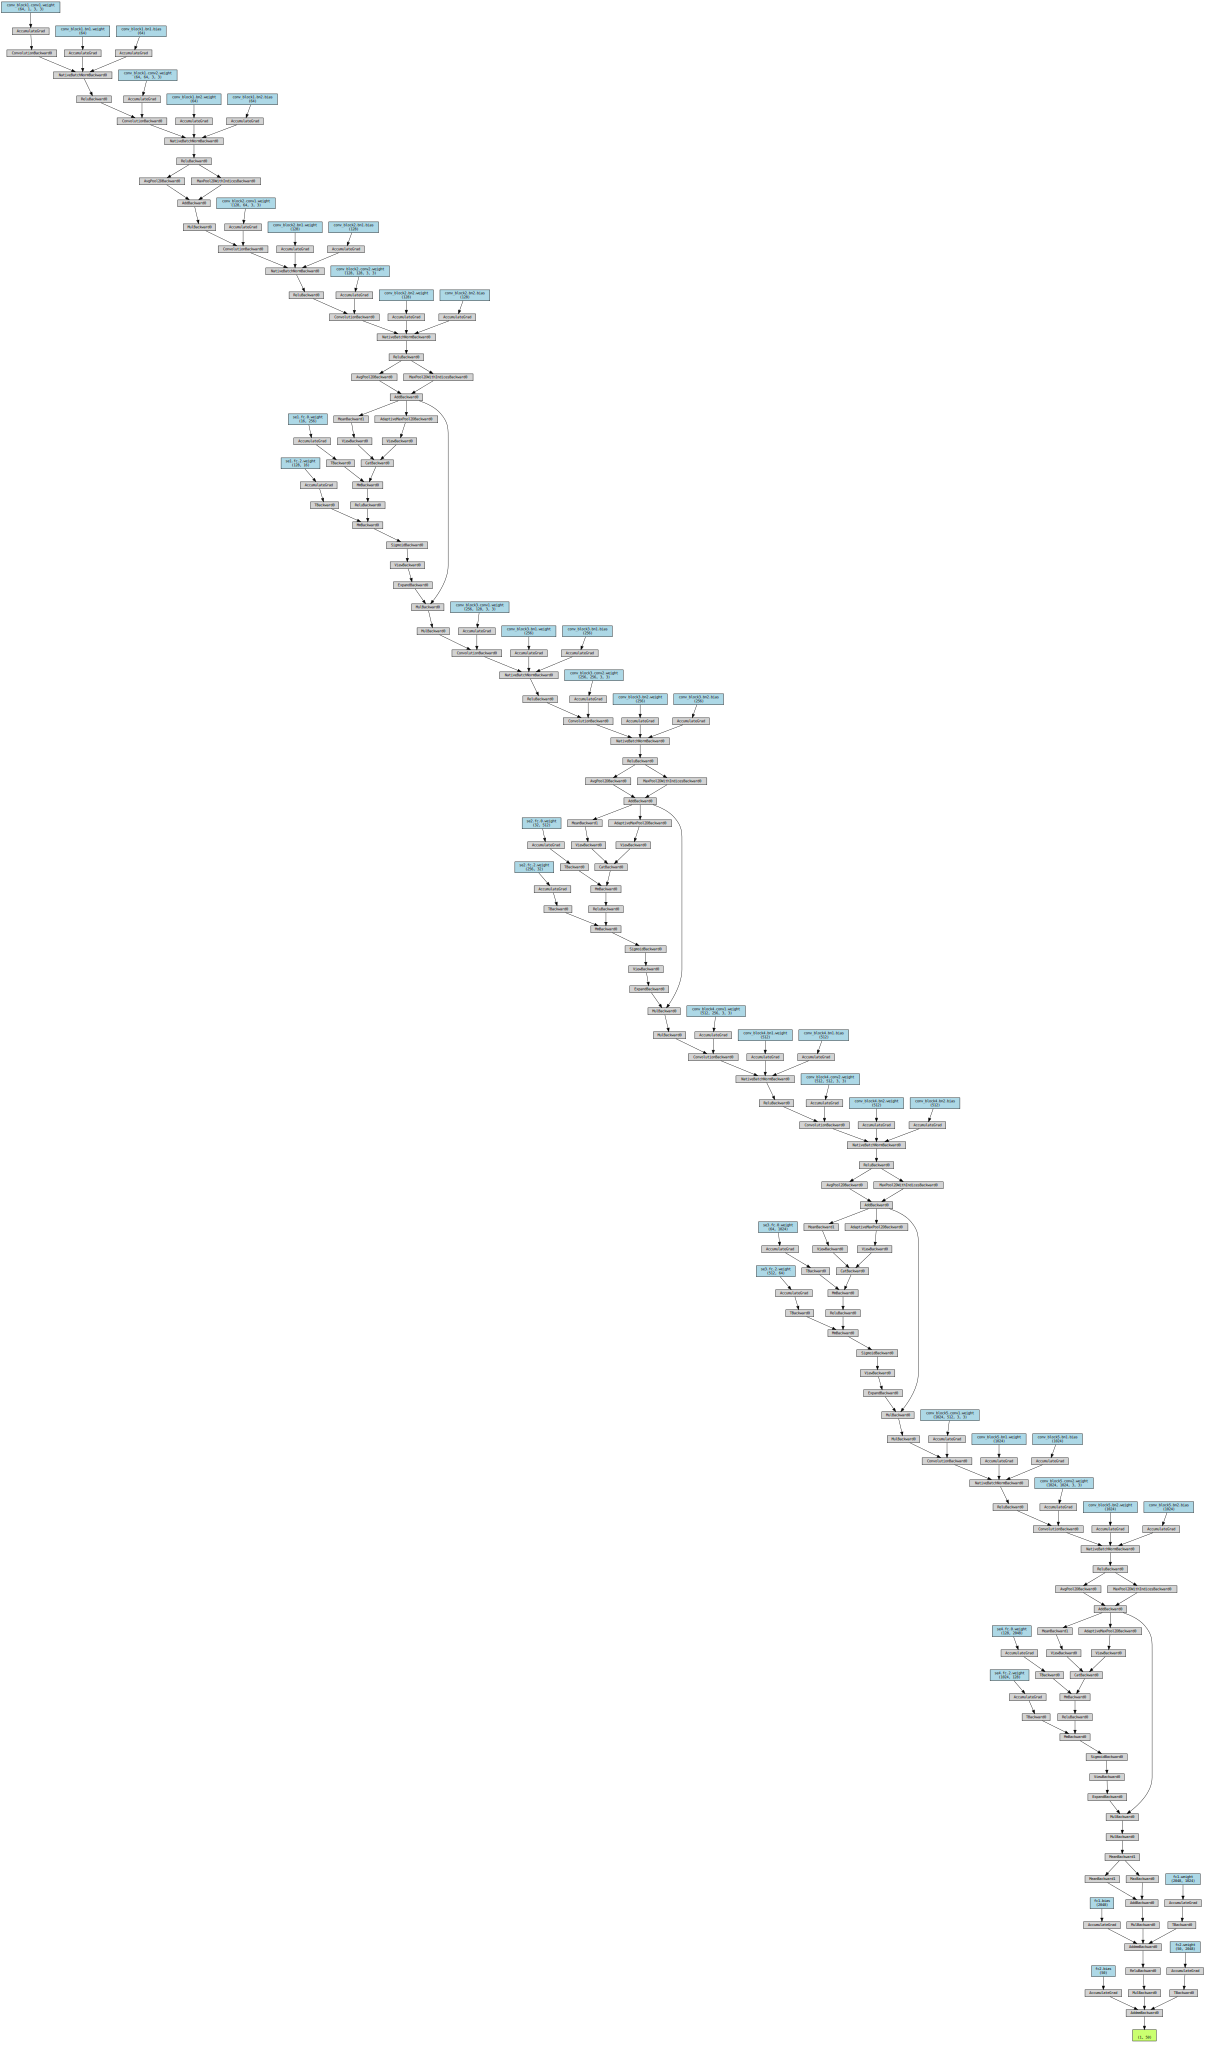

In [ ]:
from torchviz import make_dot

model = ImprovedESC50Classifier(num_classes=50)
dummy_input = torch.randn(1, 1, 64, 215)

output, _ = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_visualization", format="png")  # Save as PNG
dot  # Display in Jupyter Notebook


Using Hooks to investigate in the layers


In [ ]:
# Import necessary libraries
import torch
from torchinfo import summary

# 1. First define the FeatureExtractor class
class FeatureExtractor:
    def __init__(self, model, layer_names):
        self.model = model
        self.features = {}
        self.hooks = []

        for name, module in model.named_modules():
            if name in layer_names:
                hook = module.register_forward_hook(
                    lambda m, i, o, name=name: self.features.update({name: o})
                )
                self.hooks.append(hook)

    def get_features(self, x):
        _ = self.model(x)  # Forward pass
        return self.features

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# 2. Create a function that combines preprocessing and feature extraction
def extract_features_from_audio(audio_path, extractor, device='cpu'):
    # Preprocess audio using your existing function
    # Set augment=False since we want consistent features
    mel_spec_db = preprocess_audio(audio_path, augment=False)

    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(mel_spec_db, dtype=torch.float32)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)  # Add channel dimension
    input_tensor = input_tensor.to(device)

    # Extract features
    with torch.no_grad():
        features = extractor.get_features(input_tensor)

    return features


# Define the path
model_path = "/content/drive/MyDrive/logs_model/improved_best_model.pth"

# Initialize and load the model
model = ImprovedESC50Classifier()  # Initialize with your architecture
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cpu')  # Or 'cpu' if you're not using GPU
model.eval()  # Set to evaluation mode


# 4. Define layers to extract features from
layers_of_interest = [
    'conv_block1',
    'conv_block2',
    'se1',
    'conv_block3',
    'se2',
    'conv_block4',
    'se3',
    'conv_block5',
    'se4',
    'fc1'
]

# 5. Create extractor and get features
extractor = FeatureExtractor(model, layers_of_interest)

# 6. Extract features for a specific audio file
audio_path = '/content/drive/MyDrive/ESC-50-Dataset/ESC-50-master/audio/1-5996-A-6.wav'
features = extract_features_from_audio(audio_path, extractor)

# 7. Print the shapes of intermediate features
for name, feature in features.items():
    print(f"{name} output shape: {feature.shape}")

# 8. Clean up
extractor.remove_hooks()

summary(model, input_size=(1, 1, 128, 431))


<ipython-input-10-7581331502cb>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))


Input spectrogram shape: torch.Size([1, 1, 128, 431])
conv_block1 output shape: torch.Size([1, 64, 64, 215])
conv_block2 output shape: torch.Size([1, 128, 32, 107])
se1 output shape: torch.Size([1, 128, 32, 107])
conv_block3 output shape: torch.Size([1, 256, 16, 53])
se2 output shape: torch.Size([1, 256, 16, 53])
conv_block4 output shape: torch.Size([1, 512, 8, 26])
se3 output shape: torch.Size([1, 512, 8, 26])
conv_block5 output shape: torch.Size([1, 1024, 4, 13])
se4 output shape: torch.Size([1, 1024, 4, 13])
fc1 output shape: torch.Size([1, 2048])
Input spectrogram shape: torch.Size([1, 1, 128, 431])


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedESC50Classifier                  [1, 50]                   --
├─EnhancedConvBlock: 1-1                 [1, 64, 64, 215]          --
│    └─Conv2d: 2-1                       [1, 64, 128, 431]         576
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 431]         128
│    └─Conv2d: 2-3                       [1, 64, 128, 431]         36,864
│    └─BatchNorm2d: 2-4                  [1, 64, 128, 431]         128
├─EnhancedConvBlock: 1-2                 [1, 128, 32, 107]         --
│    └─Conv2d: 2-5                       [1, 128, 64, 215]         73,728
│    └─BatchNorm2d: 2-6                  [1, 128, 64, 215]         256
│    └─Conv2d: 2-7                       [1, 128, 64, 215]         147,456
│    └─BatchNorm2d: 2-8                  [1, 128, 64, 215]         256
├─SEBlock: 1-3                           [1, 128, 32, 107]         --
│    └─AdaptiveAvgPool2d: 2-9            [1, 128, 1, 1]            

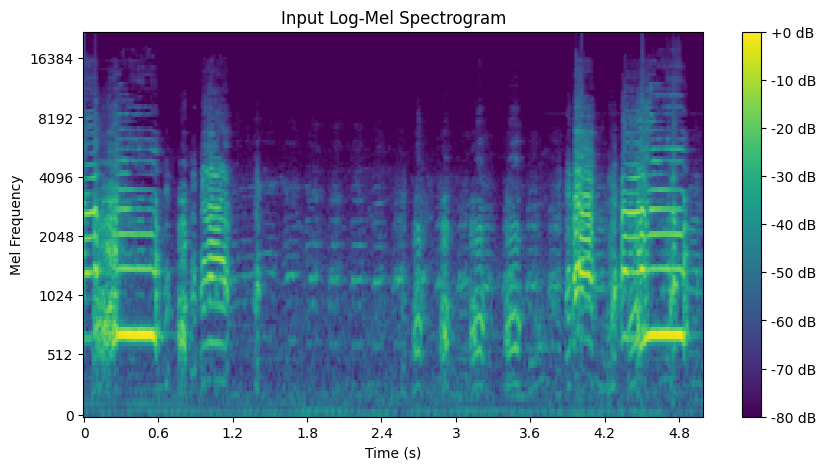

Input spectrogram shape: torch.Size([1, 1, 128, 431])


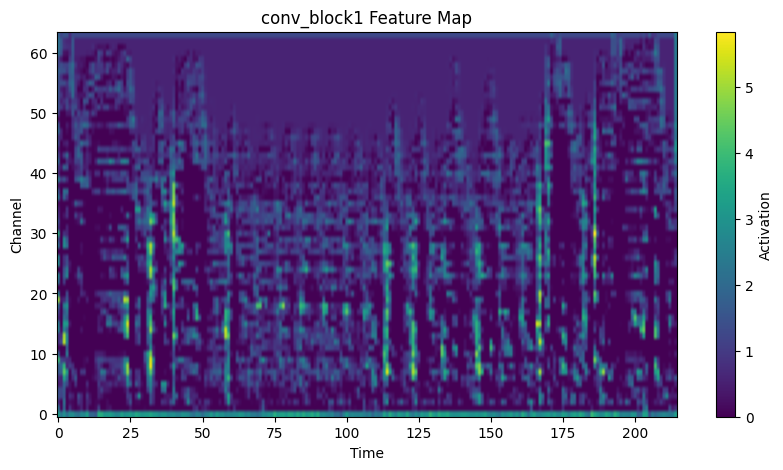

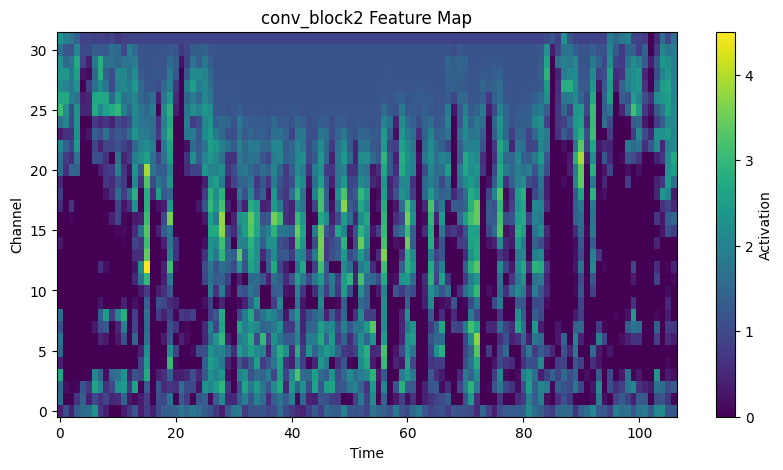

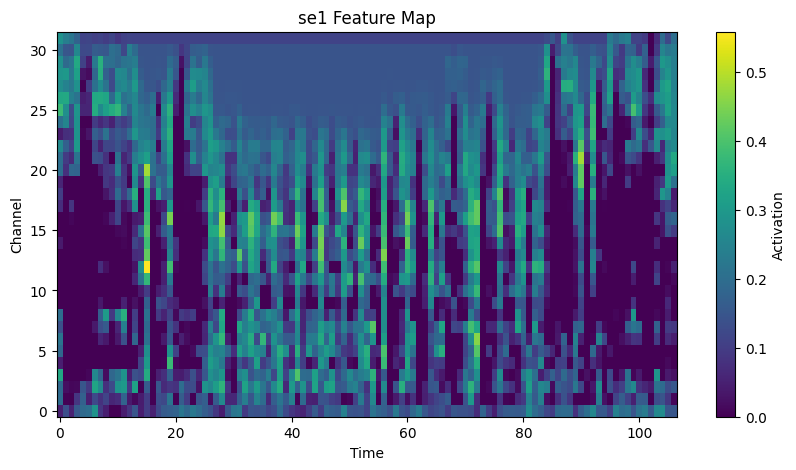

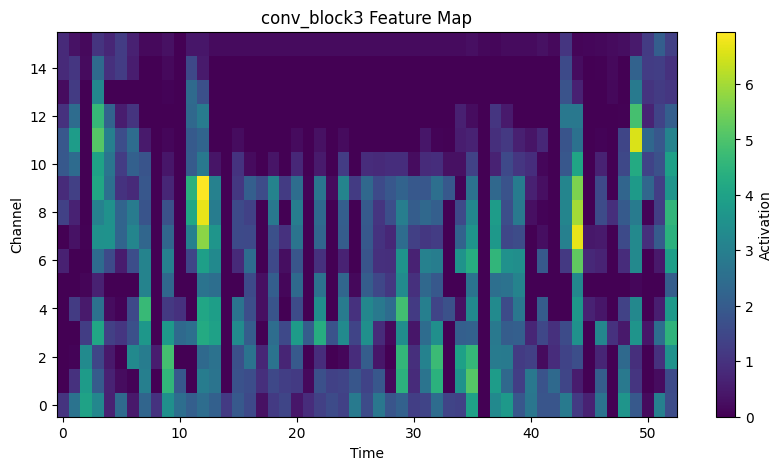

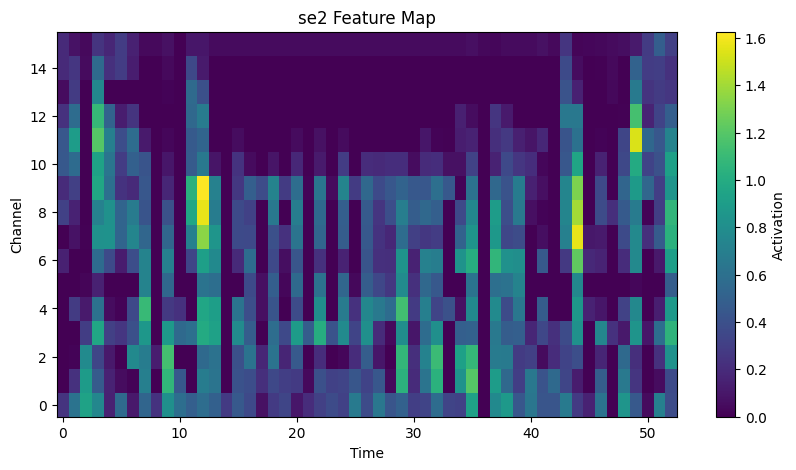

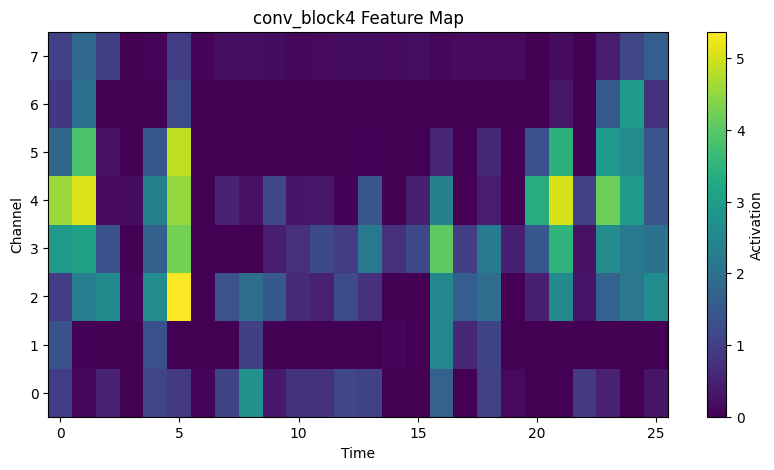

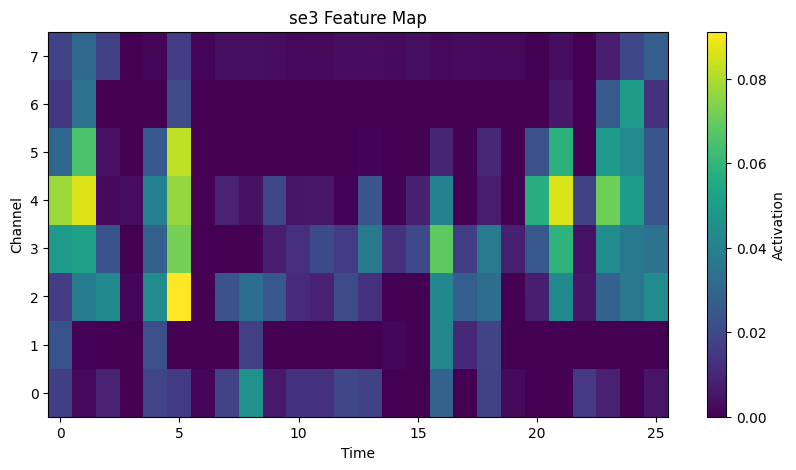

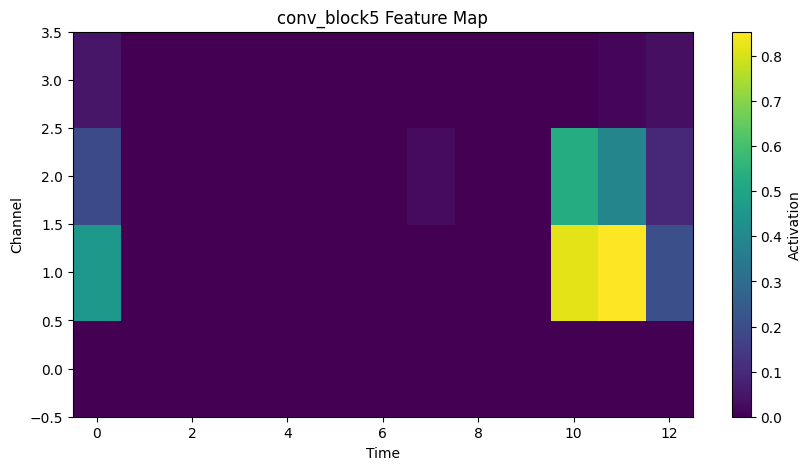

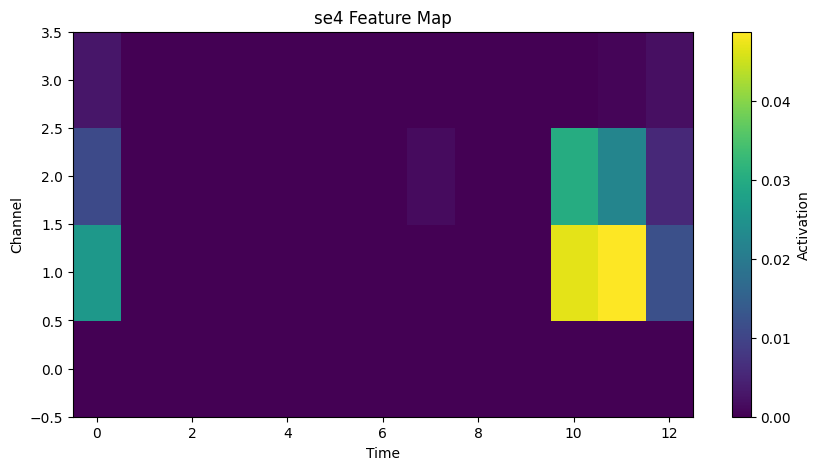

Skipping layer fc1 with output shape torch.Size([1, 2048]), not suitable for plotting.


In [ ]:
def plot_spectrogram_with_features(audio_path, feature_extractor):
    # Load and process the input spectrogram
    waveform, sample_rate = librosa.load(audio_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(
        y=waveform, sr=sample_rate, n_mels=128, hop_length=512
    )
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Plot the input spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(
        log_spectrogram, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis'
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Input Log-Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

    # Extract and visualize features
    features = extract_features_from_audio(audio_path, feature_extractor)
    for name, feature in features.items():
        if len(feature.shape) == 4:  # Check if output has 2D spatial dimensions
            feature_map = feature[0][0].detach().cpu().numpy()  # First channel of the first batch
            plt.figure(figsize=(10, 5))
            plt.imshow(feature_map, origin="lower", aspect="auto", cmap="viridis")
            plt.colorbar(label="Activation")
            plt.title(f"{name} Feature Map")
            plt.xlabel("Time")
            plt.ylabel("Channel")
            plt.show()
        else:
            print(f"Skipping layer {name} with output shape {feature.shape}, not suitable for plotting.")

# 5. Create the extractor
extractor = FeatureExtractor(model, layers_of_interest)

# 6. Plot the spectrogram and features
audio_path = '/content/drive/MyDrive/ESC-50-Dataset/ESC-50-master/audio/1-5996-A-6.wav'
plot_spectrogram_with_features(audio_path, extractor)

# 8. Clean up
extractor.remove_hooks()
